<a href="https://colab.research.google.com/github/akinahomwabella/Minnie_MUDAC_ml/blob/main/lstm_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


 Tuning Fold 1/5

 Tuning Fold 2/5

 Tuning Fold 3/5

 Tuning Fold 4/5

 Tuning Fold 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


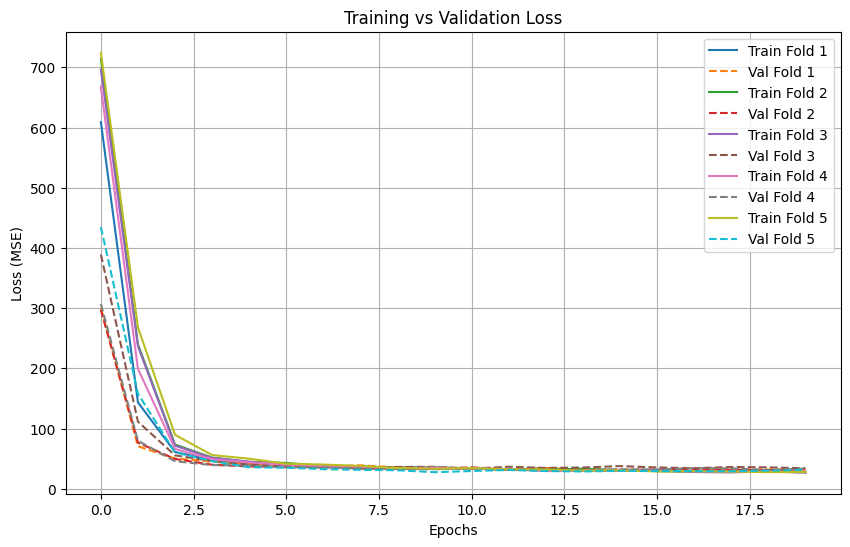


 Final Cross-Validated Metrics:
Average RMSE: 5.72
Average MAE : 4.17
Average MSE : 32.72
Average R2  : 0.9147


In [ ]:
# Install dependencies
!pip install keras-tuner openpyxl

# Import libraries
import pandas as pd
import numpy as np
import keras_tuner as kt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
import joblib

# Load training data
df_train = pd.read_excel("/content/sample_data/ML_Training_Test_Dataset-final.xlsx", sheet_name="Train Data")

# Set number of early rows to keep (simulate early-stage interactions)
early_steps = 3

# Group by Match ID and create sequences
grouped = df_train.groupby('Match ID 18Char')
label_encoders = {}
sequences, targets, match_ids = [], [], []

for match_id, group in grouped:
    group = group.sort_values('Match Activation Date')
    group = group.head(early_steps)  # only early-stage rows

    if group.empty:
        continue

    features_df = group.drop(columns=['Match ID 18Char', 'Match Length'], errors='ignore')

    for col in features_df.select_dtypes(include='object').columns:
        if col not in label_encoders:
            label_encoders[col] = LabelEncoder()
            label_encoders[col].fit(df_train[col].astype(str))
        features_df[col] = label_encoders[col].transform(features_df[col].astype(str))

    features_df = features_df.fillna(0)
    sequences.append(features_df.values)
    targets.append(group['Match Length'].iloc[0])
    match_ids.append(match_id)

# Save encoders
joblib.dump(label_encoders, 'label_encoders.pkl')

# Pad sequences
X = pad_sequences(sequences, dtype='float32', padding='post', value=0.0)
y = np.array(targets)

# Normalize features
scalers = [StandardScaler() for _ in range(X.shape[2])]
for i in range(X.shape[2]):
    col_vals = np.concatenate([x[:, i] for x in sequences])
    scalers[i].fit(col_vals.reshape(-1, 1))
    for j in range(len(X)):
        X[j, :, i] = scalers[i].transform(X[j, :, i].reshape(-1, 1)).flatten()
joblib.dump(scalers, 'scalers.pkl')

# Define hypermodel builder
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X.shape[1], X.shape[2])))
    model.add(Masking(mask_value=0.0))
    model.add(LSTM(
        units=hp.Int("lstm_units_1", 32, 128, step=32),
        return_sequences=True if hp.Boolean("add_second_lstm") else hp.Boolean("return_seq", default=False)
    ))
    if hp.Boolean("add_second_lstm"):
        model.add(Dropout(hp.Float("dropout_1", 0.2, 0.5, step=0.1)))
        model.add(LSTM(units=hp.Int("lstm_units_2", 32, 64, step=32)))

    model.add(Dropout(hp.Float("dropout_final", 0.2, 0.5, step=0.1)))
    model.add(Dense(hp.Int("dense_units", 16, 64, step=16), activation="relu"))
    model.add(Dense(1))

    model.compile(
        optimizer=Adam(hp.Float("lr", 1e-4, 1e-2, sampling="log")),
        loss="mse"
    )
    return model

# Cross-validation setup
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Hyperparameter tuning
tuner = kt.RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=10,
    directory="keras_tuner_dir",
    project_name="match_lstm_cv_tuning"
)

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\n Tuning Fold {fold + 1}/{num_folds}")
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=0)

# Get best hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0]

# Train and evaluate final model
mse_scores, rmse_scores, mae_scores, r2_scores = [], [], [], []
all_preds, all_true, all_match_ids = [], [], []
fold_losses = []

for train_index, val_index in kf.split(X):
    model = build_model(best_hp)
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=0)
    preds = model.predict(X_val).flatten()

    mse = mean_squared_error(y_val, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, preds)
    r2 = r2_score(y_val, preds)

    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)

    all_preds.extend(preds)
    all_true.extend(y_val)
    all_match_ids.extend(np.array(match_ids)[val_index])
    fold_losses.append(history.history)

# Save predictions
df_preds = pd.DataFrame({
    'Match ID 18Char': all_match_ids,
    'Predicted Match Length': all_preds,
    'Actual Match Length': all_true
})
df_final = df_train.drop_duplicates(subset='Match ID 18Char').merge(df_preds, on='Match ID 18Char', how='left')
df_final.to_excel("/content/ML_Training_Test_Dataset_EarlyWindow.xlsx", index=False)

# Plot training vs validation loss
plt.figure(figsize=(10, 6))
for i, losses in enumerate(fold_losses):
    plt.plot(losses['loss'], label=f'Train Fold {i+1}')
    plt.plot(losses['val_loss'], linestyle='--', label=f'Val Fold {i+1}')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Final Metrics
print("\n Final Cross-Validated Metrics:")
print(f"Average RMSE: {np.mean(rmse_scores):.2f}")
print(f"Average MAE : {np.mean(mae_scores):.2f}")
print(f"Average MSE : {np.mean(mse_scores):.2f}")
print(f"Average R2  : {np.mean(r2_scores):.4f}")

model.save('lstm_final_model_early_window.keras')


In [ ]:


#  Load trained model
model = load_model('lstm_final_model_early_window.keras')

#  Load test data
df_test = pd.read_excel("/content/sample_data/ML_Training_Test Dataset.xlsx", sheet_name="Test Data")

# Load label encoders and scalers from training
label_encoders = joblib.load("label_encoders.pkl")
scalers = joblib.load("scalers.pkl")

# Get model expected number of features
expected_num_features = model.input_shape[2]
print(f" Model expects {expected_num_features} features per timestep.")

# Group and process test data
grouped_test = df_test.groupby('Match ID 18Char')
sequences_test, test_ids = [], []

# Columns to ignore
cols_to_ignore = [
    'Match ID 18Char', 'Little Lat', 'Little Long',
    'Big County', 'Big State', 'Big Lat', 'Big Long', 'Distance (Mi)'
]

# Set early step count
early_steps = 3

for match_id, group in grouped_test:
    group = group.sort_values('Match Activation Date').head(early_steps)
    features_df = group.drop(columns=cols_to_ignore, errors='ignore')

    #encoding for unseen values
    for col in features_df.select_dtypes(include='object').columns:
        if col in label_encoders:
            known_classes = set(label_encoders[col].classes_)
            features_df[col] = features_df[col].astype(str).apply(lambda x: x if x in known_classes else '__unknown__')

            if '__unknown__' not in label_encoders[col].classes_:
                all_classes = np.append(label_encoders[col].classes_, '__unknown__')
                label_encoders[col].classes_ = all_classes

            features_df[col] = label_encoders[col].transform(features_df[col])
        else:
            features_df[col] = 0
    # Fill missing values
    features_df = features_df.fillna(0)

    # Align feature count to training
    while features_df.shape[1] < expected_num_features:
        features_df[f'__pad_{features_df.shape[1]}'] = 0
    if features_df.shape[1] > expected_num_features:
        features_df = features_df.iloc[:, :expected_num_features]

    sequences_test.append(features_df.values)
    test_ids.append(match_id)

# Pad sequences to same length
X_test = pad_sequences(sequences_test, dtype='float32', padding='post', value=0.0)

# Normalize using saved training scalers
num_features_to_scale = min(X_test.shape[2], len(scalers))
for i in range(num_features_to_scale):
    for j in range(len(X_test)):
        X_test[j, :, i] = scalers[i].transform(X_test[j, :, i].reshape(-1, 1)).flatten()

# Predict Match Length
preds_test = model.predict(X_test).flatten()

#  Save predictions
df_preds_test = pd.DataFrame({
    'Match ID 18Char': test_ids,
    'Predicted Match Length': preds_test
})
df_preds_test.to_excel("/content/Predicted_Match_Length_TestSet.xlsx", index=False)
print("Predictions complete and saved to Predicted_Match_Length_TestSet.xlsx")




 Model expects 79 features per timestep.
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
Predictions complete and saved to Predicted_Match_Length_TestSet.xlsx
